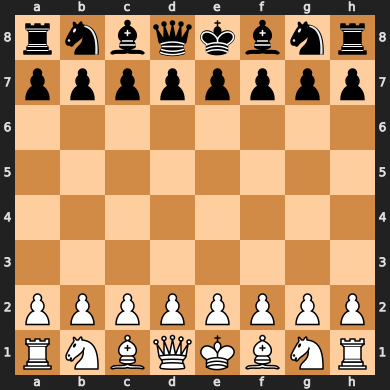

In [14]:
import chess

board = chess.Board()
board

In [15]:
board.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

In [16]:
from stockfish import Stockfish

stockfish=Stockfish(r"C:\Users\congcong\Desktop\FYP\stockfish_14_win_x64\stockfish_14_x64.exe")
stockfish.set_depth(20)#How deep the AI looks
stockfish.set_skill_level(20)#Highest rank stockfish
stockfish.get_parameters()

{'Write Debug Log': 'false',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Threads': 1,
 'Ponder': 'false',
 'Hash': 16,
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 30,
 'Minimum Thinking Time': 20,
 'Slow Mover': 80,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350,
 'UCI_ShowWDL': 'false'}

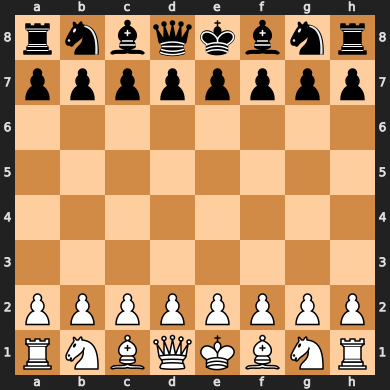

In [17]:
#To interface with our stored board we use FEN
display(board)
ev=stockfish.set_fen_position(board.fen())
ev=stockfish.get_evaluation()

cp is "centipawans". 100 equals a 1 pawn advantage

In [21]:
          
ev=stockfish.set_fen_position('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR')
ev=stockfish.get_evaluation()
print(ev)

{'type': 'cp', 'value': -16}


In [6]:
#Standard point values for different pieces. Lowercase is white piece and uppercase is black
piece_scores={
    "p": 1,
    "P": -1,
    "r": 5,
    "R": -5,
    "n": 3,
    "N": -3,
    "b": 3,
    "B": -3,
    "q": 9,
    "Q": -9
}

In [7]:
!nvidia-smi

Mon Aug 15 16:58:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8     7W /  N/A |    134MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [8]:
import numpy as np
import random
import chess
import chess.engine
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Flatten,Reshape
from keras.layers.convolutional import Conv2D
from IPython.display import clear_output

In [9]:
# Configuration paramaters for the epsilon-greedy algorithm
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 100
num_actions = 4096

In [10]:
#variables settings

# Instantiate a keras optimizer.
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
running_reward = 0
episode_count = 0
frame_count = 0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber() 
len_episodes = 0
iterations = 150

In [11]:
#Chess part (board_conversion)
#filtrer les coups legaux 
def filter_legal_moves(board,logits):
    filter_mask = np.zeros(logits.shape)
    legal_moves = board.legal_moves
    for legal_move in legal_moves:
        from_square = legal_move.from_square
        to_square = legal_move.to_square
        idx = move2num[chess.Move(from_square,to_square)]
        filter_mask[idx] = 1
    new_logits = logits*filter_mask
    return new_logits

num2move = {}
move2num = {}
counter = 0
#les mouvement executer 
for from_sq in range(64):
    for to_sq in range(64):
        num2move[counter] = chess.Move(from_sq,to_sq)
        move2num[chess.Move(from_sq,to_sq)] = counter
        counter += 1

In [12]:
def translate_board(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append(chess_dict['.'])
            else:
                foo2.append(chess_dict[thing])
        foo.append(foo2)
    return np.array(foo)

#Uppercase => White
#Lowercase => Black
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

In [13]:
#Environement
class ChessEnv():
    def __init__(self):
        self.board = chess.Board()
        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []
        self.episode_reward_history = []
        pass

#1. Return State
#This function simply returns a vector that fully expresses the 
#information accessible to the agent environment, that can be 
#plugged into the neural network        
    def translate_board(self):
        return translate_board(self.board)
    def reset(self):
        self.board = chess.Board()
        if len(self.rewards_history) > max_memory_length:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]
        return translate_board(self.board)
    
#2. Accept Action
#This function accepts an action and changes the state of the 
#environment by this action.    
    def step(self,action):
        reward = 0
        done = False
        
        state = self.translate_board()
        self.board.push(action)
        state_next = self.board
        state_next = translate_board(state_next)
        
        if self.board.is_checkmate():
            reward = 100
        if self.board.is_game_over():
            done = True
    
        self.action_history.append(move2num[action])
        self.state_history.append(state)
        self.state_next_history.append(state_next)
        self.done_history.append(done)
        self.rewards_history.append(reward)
        return state_next,reward,done

#3.update q_value  le callcule du cout et l'insere dans la table ds q value 
    def update_q_values(self):
        indices = np.random.choice(range(len(self.done_history)), size=batch_size)
            
        state_sample = np.array([self.state_history[i] for i in indices])
        state_next_sample = np.array([self.state_next_history[i] for i in indices])
        rewards_sample = [self.rewards_history[i] for i in indices]
        action_sample = [self.action_history[i] for i in indices]
        done_sample = tf.convert_to_tensor(
            [float(self.done_history[i]) for i in indices]
        )
        
        future_rewards = model_target.model.predict(state_next_sample)
        
        updated_q_values = rewards_sample + gamma * tf.reduce_max(
            future_rewards, axis=1
        )

        updated_q_values = updated_q_values * (1 - done_sample) - done_sample

        masks = tf.one_hot(action_sample, num_actions)
        return state_sample,masks,updated_q_values
    
env = ChessEnv()

In [14]:
class Q_model():
    def __init__(self):
        self.model = self.create_q_model()

    def create_q_model(self):
     #l'axe de l'echantillon :8par 8 avec 12 piece distincte 
        input_layer = keras.Input(shape=(8, 8, 12)) 
       

        # Convolutions on the frames on the screen 
        x = Conv2D(filters=64,padding="same",kernel_size = 2,strides = (2,2))(input_layer)
        x = Conv2D(filters=128,padding="same",kernel_size=2,strides = (2,2))(x)
        x = Conv2D(filters=256,padding="same",kernel_size=2,strides = (2,2))(x)
        x = Flatten()(x)

        action = Dense(4096,activation = 'softmax')(x)
        return keras.Model(inputs=input_layer, outputs=action)
    
    #prédire et renvoie l'action à exécuter based on previous experience
    def predict(self,env):
        state_tensor = tf.convert_to_tensor(env.translate_board())
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        action_space = filter_legal_moves(env.board,action_probs[0])
        action = np.argmax(action_space, axis=None)
        move= num2move[action]
        return move,action
    
    #explore action space and choose the action avec le n° le plus grand  
    def explore(self,env):
        action_space = np.random.randn(4096)
        action_space = filter_legal_moves(env.board,action_space)
        action = np.argmax(action_space, axis=None)
        move= num2move[action]
        return move,action
        
    
model = Q_model()
model_target = Q_model()

In [15]:
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 12)]        0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         32896     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         131328    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
Total params: 1,220,032
Trainable params: 1,220,032
Non-train